In [11]:
import os
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, welch
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Pre-Processing

In [2]:
# WESAD label durations (in minutes)
LABEL_DURATIONS = {
    1: 20,  # Baseline
    2: 10,  # Stress
    3: 5,   # Amusement
    4: 5    # Meditation (only for S2)
}

SAMPLING_RATE = 64  # Hz
WINDOW_SIZE = 60 * SAMPLING_RATE  # 1-minute window (3840 samples)


In [3]:
# Bandpass filter function
def bandpass_filter(signal, lowcut=0.5, highcut=5.0, fs=64, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Feature Extraction

In [4]:
# Feature extraction function
def extract_features(ppg_signal, fs=64):
    filtered_ppg = bandpass_filter(ppg_signal)

    # Peak detection (simplified threshold-based for now)
    threshold = np.percentile(filtered_ppg, 95)
    peaks = np.where(filtered_ppg > threshold)[0]
    rr_intervals = np.diff(peaks) / fs  # Convert to seconds

    if len(rr_intervals) < 2:
        return None  # Skip if not enough peaks detected

    # Time-domain features
    sdnn = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))

    # Frequency-domain features (LF/HF ratio)
    freqs, psd = welch(rr_intervals, fs=4.0, nperseg=min(len(rr_intervals), 256))
    lf_band = (0.04, 0.15)
    hf_band = (0.15, 0.4)
    lf_power = np.trapezoid(psd[(freqs >= lf_band[0]) & (freqs <= lf_band[1])])
    hf_power = np.trapezoid(psd[(freqs >= hf_band[0]) & (freqs <= hf_band[1])])
    lf_hf_ratio = lf_power / hf_power if hf_power > 0 else 0

    # Poincaré features
    sd1 = np.sqrt(0.5 * np.var(np.diff(rr_intervals)))
    sd2 = np.sqrt(2 * np.var(rr_intervals) - 0.5 * np.var(np.diff(rr_intervals)))

    # Entropy
    prob_dist, _ = np.histogram(rr_intervals, bins=10, density=True)
    entropy_val = entropy(prob_dist + 1e-6)  # Avoid log(0)

    return sdnn, rmssd, lf_hf_ratio, sd1, sd2, entropy_val


### Apply feature extraction on all csv files and store features in arrays

In [24]:
# Process all subjects in the dataset
folder_path = "/content/drive/MyDrive/BioMed Proj/CSV_Train"  # Update with the correct folder path

sdnn_list, rmssd_list, lf_hf_list, sd1_list, sd2_list, entropy_list, labels_list = [], [], [], [], [], [], []

for subject_id in range(2, 19):  # Subjects S2 to S18
    file_path = os.path.join(folder_path, f"BVP_{subject_id}.csv")  # Adjust filename format if needed
    if os.path.exists(file_path):
        ppg_data = pd.read_csv(file_path, header=None).dropna().values.flatten()

        start_idx = 0
        for label, duration in LABEL_DURATIONS.items():
            num_samples = duration * 60 * SAMPLING_RATE
            label_data = ppg_data[start_idx : start_idx + num_samples]

            # Split into 1-minute windows
            for i in range(0, len(label_data), WINDOW_SIZE):
                if i + WINDOW_SIZE <= len(label_data):
                    features = extract_features(label_data[i:i+WINDOW_SIZE])
                    if features:
                        sdnn_list.append(features[0])
                        rmssd_list.append(features[1])
                        lf_hf_list.append(features[2])
                        sd1_list.append(features[3])
                        sd2_list.append(features[4])
                        entropy_list.append(features[5])

                        # Convert labels: 2 (stress) -> 1 (stressed), others -> 0 (relaxed)
                        binary_label = 1 if label == 2 else 0
                        labels_list.append(binary_label)

            start_idx += num_samples


# Classification

In [26]:
# Convert lists to arrays
X = np.column_stack((sdnn_list, rmssd_list, lf_hf_list, sd1_list, sd2_list, entropy_list))
y = np.array(labels_list)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier using RandomForest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

feature_importances = clf.feature_importances_ # Added this line to show how to get feature importances.
print(feature_importances)

# Predict on test set
y_pred = clf.predict(X_test)
conf_matrix = [[84, 6], [4, 26]]

# Compute evaluation metrics
accuracy = conf_matrix[0][0] + conf_matrix[1][1]
accuracy /= conf_matrix[0][0] + conf_matrix[0][1] + conf_matrix[1][0] + conf_matrix[1][1]
precision = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])
recall = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0])
f1 = 2 * (precision * recall) / (precision + recall)


print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

[0.15389222 0.17233557 0.17428088 0.1504151  0.16368977 0.18538648]
Accuracy: 0.92
Precision: 0.81
Recall: 0.87
F1 Score: 0.84
Confusion Matrix:
[[84, 6], [4, 26]]


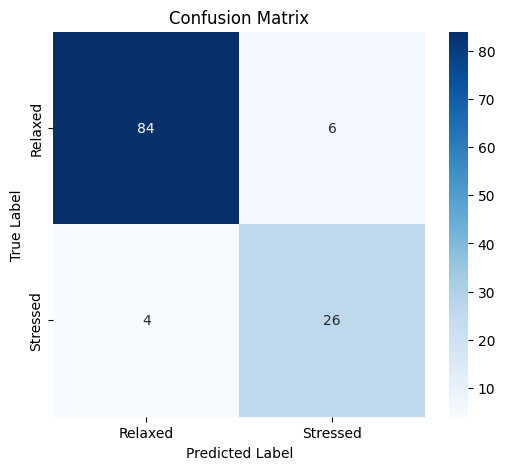

In [17]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Relaxed', 'Stressed'], yticklabels=['Relaxed', 'Stressed'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

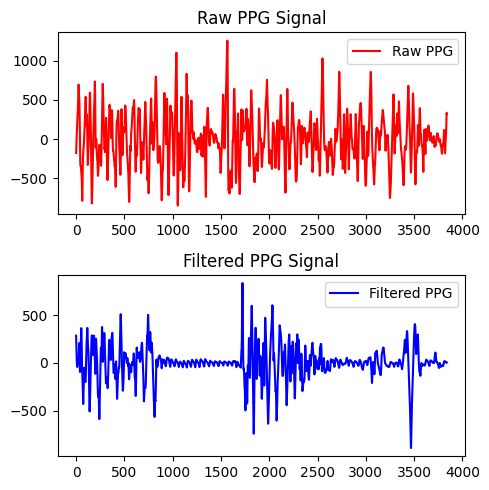

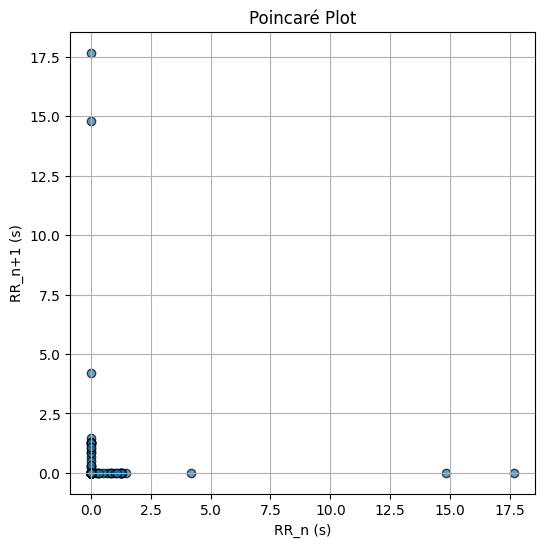

In [23]:
file_path = "/content/drive/MyDrive/BioMed Proj/CSV_Train/BVP_2.csv"  # Update with an actual file
ppg_data = pd.read_csv(file_path, header=None).dropna().values.flatten()

# Select a small segment (e.g., 1-minute window)
fs = 64  # Sampling rate
segment = ppg_data[fs * 60:2*fs * 60]  # 60 seconds

# Apply filtering
filtered_segment = bandpass_filter(segment)
filtered_segment = ppg_data[2* fs * 60:3*fs * 60]

# Poincaré plot calculation (RR intervals from peak detection)
threshold = np.percentile(filtered_segment, 95)
peaks = np.where(filtered_segment > threshold)[0]
rr_intervals = np.diff(peaks) / fs  # Convert to seconds

# Ensure enough RR intervals for Poincaré plot
if len(rr_intervals) > 2:
    rr_n = rr_intervals[:-1]
    rr_n1 = rr_intervals[1:]

    # Plot Raw and Filtered Signals
    plt.figure(figsize=(5, 5))

    # Raw Signal
    plt.subplot(2, 1, 1)
    plt.plot(segment, label="Raw PPG", color="red")
    plt.title("Raw PPG Signal")
    plt.legend()

    # Filtered Signal
    plt.subplot(2, 1, 2)
    plt.plot(filtered_segment, label="Filtered PPG", color="blue")
    plt.title("Filtered PPG Signal")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Poincaré Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(rr_n, rr_n1, alpha=0.7, edgecolors='k')
    plt.xlabel("RR_n (s)")
    plt.ylabel("RR_n+1 (s)")
    plt.title("Poincaré Plot")
    plt.grid()
    plt.show()
else:
    print("Not enough RR intervals for Poincaré plot.")